In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
import sklearn.metrics as metrics

Using TensorFlow backend.


In [4]:
train = pd.read_csv("/content/drive/My Drive/emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("/content/drive/My Drive/emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("/content/drive/My Drive/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

HEIGHT = 28
WIDTH = 28

#Dividing Train data into train_x and train_y
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

#Dividing Test data into test_x and test_y
test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

Train: (112799, 785), Test: (18799, 785), Map: (47,)


In [5]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

#Images by default are rotated hence bring them back to normal form by rotating 270 degree

train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

#Normalise the data
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

num_classes = train_y.nunique()

#Convert the output atrribute into categorical data
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

#Split the train data into train and validation 
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)
train_y:  (112799, 47)
test_y:  (18799, 47)


In [7]:
model = Sequential()

#Adding 1st Convolution block
model.add(Conv2D(filters=256, kernel_size=(3,3), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

#Adding 2nd Convolution block
model.add(Conv2D(filters=128, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

#Adding 3rd Convolution block
model.add(Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.4))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(.4))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 256)       2560      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       295040    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)         

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint("/content/drive/My Drive/model1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(train_x, train_y, epochs=50, batch_size=200, verbose=1, \
                    validation_data=(val_x, val_y), callbacks=[checkpoint])

Train on 101519 samples, validate on 11280 samples
Epoch 1/50
101519/101519 [==============================] - 12s 121us/step - loss: 0.7926 - acc: 0.7463 - val_loss: 0.4506 - val_acc: 0.8426

Epoch 00001: val_acc improved from -inf to 0.84264, saving model to /content/drive/My Drive/model1.h5
Epoch 2/50
101519/101519 [==============================] - 11s 111us/step - loss: 0.5963 - acc: 0.8044 - val_loss: 0.3977 - val_acc: 0.8562

Epoch 00002: val_acc improved from 0.84264 to 0.85621, saving model to /content/drive/My Drive/model1.h5
Epoch 3/50
101519/101519 [==============================] - 11s 110us/step - loss: 0.5226 - acc: 0.8263 - val_loss: 0.4003 - val_acc: 0.8563

Epoch 00003: val_acc improved from 0.85621 to 0.85629, saving model to /content/drive/My Drive/model1.h5
Epoch 4/50
101519/101519 [==============================] - 11s 112us/step - loss: 0.4850 - acc: 0.8365 - val_loss: 0.3556 - val_acc: 0.8660

Epoch 00004: val_acc improved from 0.85629 to 0.86605, saving model t

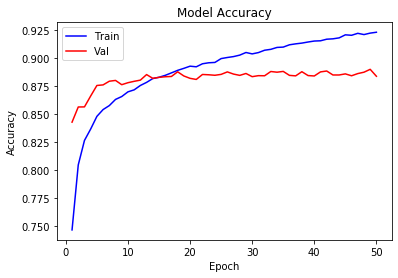

In [10]:
#plot accuracy and loss
def plotgraph(epochs, acc, val_acc,title,Xtitle):
    #Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title(title)
    plt.ylabel(Xtitle)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1,len(acc)+1)

plotgraph(epochs, acc, val_acc,'Model Accuracy','Accuracy')

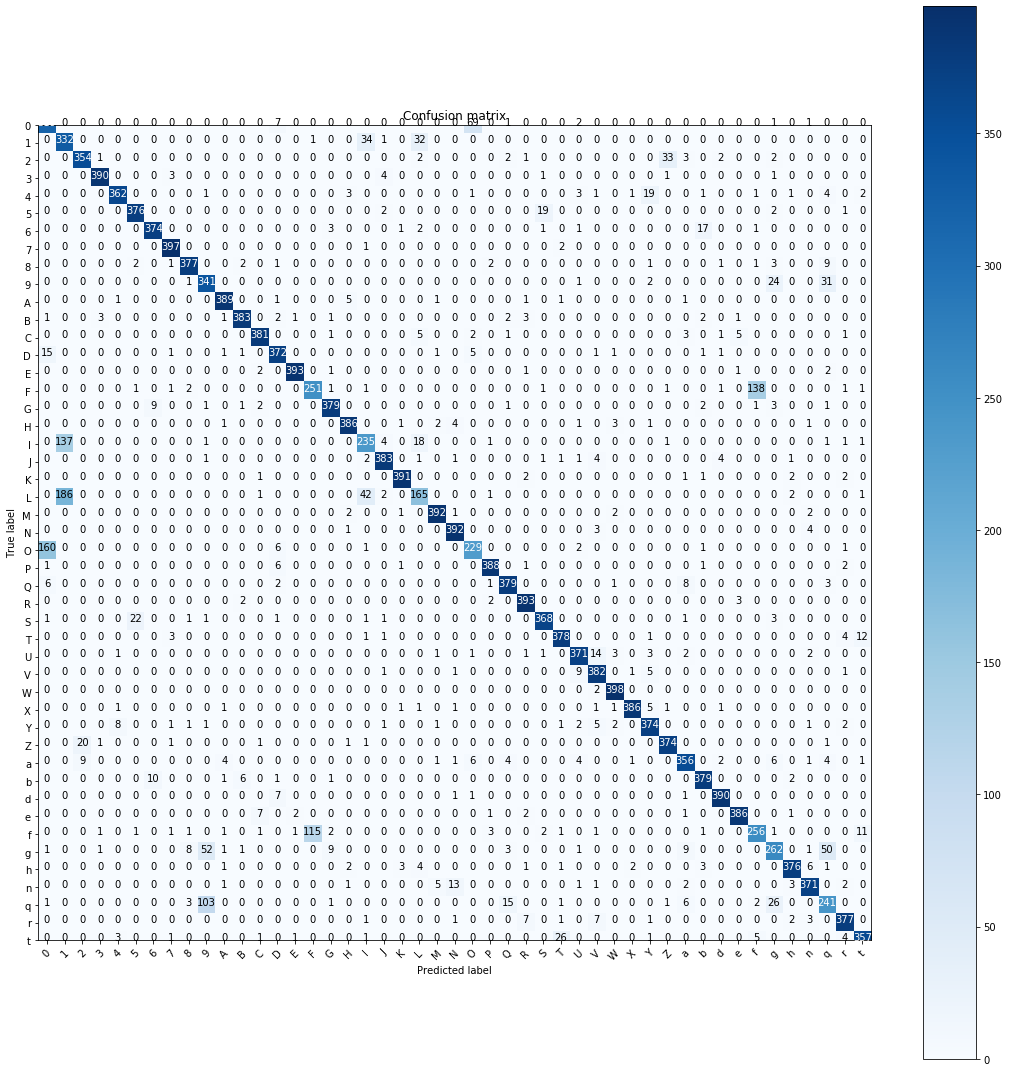

In [13]:
finalPrediction = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","a","b","d","e","f","g","h","n","q","r","t"]

y_pred = model.predict(test_x)
cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, finalPrediction, rotation=45)
    plt.yticks(tick_marks, finalPrediction)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, classes=range(47))

In [15]:
#Test Accuracy
loaded_model=load_model("/content/drive/My Drive/model1.h5")

score = loaded_model.evaluate(test_x, test_y, verbose=1)

print("Test accuracy:", score[1])

18799/18799 [==============================] - 2s 98us/step
Test accuracy: 0.8862173519963197


In [0]:
#Predicting the output for given Image

finalPrediction = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z","a","b","d","e","f","g","h","n","q","r","t"]

#Reading Input
print("Enter the Location of image : ")
path=input()
print("Enter no of Letters/Digits : ")
n=int(input())

gray=cv2.imread(path,0)
(thresh,gray1)=cv2.threshold(gray,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#Resizing input image
gray1=cv2.resize((255-gray1),(28*n,28))
print("Output = ",end='')
for i in range(n):
  #creating Sub-Images for the given image
  sub_image = gray1[0: 28*n, i*28:(i+1)*28]
  img=sub_image.flatten()/255.0
  image=img.reshape(-1,28,28,1)
  
  #plot the Image
  #plt.figure()
  plt.imshow(sub_image)

  result=loaded_model.predict(image)
  x=np.where(result[0]==np.amax(result[0]))
  f=x[0][0]
  if(result[0][x]>0.5):
  #display the prediction
    print(finalPrediction[f],end='')
  else:
    print('Not found')